In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r"EasyVisa.csv")
df.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


### Data Cleaning

#### Check for null values

In [3]:
df.isnull().sum()

case_id                  0
continent                0
education_of_employee    0
has_job_experience       0
requires_job_training    0
no_of_employees          0
yr_of_estab              0
region_of_employment     0
prevailing_wage          0
unit_of_wage             0
full_time_position       0
case_status              0
dtype: int64

* **There are no missing values**

#### Duplicated values

In [5]:
df.duplicated().sum()

0

* **No duplicate values**

Remove case_id from dataset as it cannot be used in model training

In [7]:
df = df.drop(columns='case_id')
df.columns

Index(['continent', 'education_of_employee', 'has_job_experience',
       'requires_job_training', 'no_of_employees', 'yr_of_estab',
       'region_of_employment', 'prevailing_wage', 'unit_of_wage',
       'full_time_position', 'case_status'],
      dtype='object')

## Feature Engineering

### Feature Extraction


In [10]:
# getting age of company

from datetime import date

todays_date = date.today()
current_year = todays_date.year
current_year

2024

In [11]:
df['age_company'] = current_year - df['yr_of_estab']
df['age_company']

0         17
1         22
2         16
3        127
4         19
        ... 
25475     16
25476     18
25477    114
25478    137
25479     64
Name: age_company, Length: 25480, dtype: int64

In [12]:
# dropping year of established as we got the age_comany column
df = df.drop(columns='yr_of_estab')

In [15]:
# dropping require_job_training column as it doesn't correlate well with target column
df = df.drop(columns='requires_job_training')

### Type of features

#### Numeric Features

In [13]:
num_features = df.select_dtypes(exclude='object')
num_features

,no_of_employees,prevailing_wage,age_company
0,14513,592.2029,17
1,2412,83425.6500,22
2,44444,122996.8600,16
3,98,83434.0300,127
4,1082,149907.3900,19
...,...,...,...
25475,2601,77092.5700,16
25476,3274,279174.7900,18
25477,1121,146298.8500,114
25478,1918,86154.7700,137


#### Categorical features

In [16]:
cat_features = df.select_dtypes(include='object')
cat_features

,continent,education_of_employee,has_job_experience,region_of_employment,unit_of_wage,full_time_position,case_status
0,Asia,High School,N,West,Hour,Y,Denied
1,Asia,Master's,Y,Northeast,Year,Y,Certified
2,Asia,Bachelor's,N,West,Year,Y,Denied
3,Asia,Bachelor's,N,West,Year,Y,Denied
4,Africa,Master's,Y,South,Year,Y,Certified
...,...,...,...,...,...,...,...
25475,Asia,Bachelor's,Y,South,Year,Y,Certified
25476,Asia,High School,Y,Northeast,Year,Y,Certified
25477,Asia,Master's,Y,South,Year,N,Certified
25478,Asia,Master's,Y,West,Year,Y,Certified


### Split into independent and dependent features

In [17]:
X = df.drop(columns = 'case_status')
y = df['case_status']

In [18]:
X.head()

,continent,education_of_employee,has_job_experience,no_of_employees,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,age_company
0,Asia,High School,N,14513,West,592.2029,Hour,Y,17
1,Asia,Master's,Y,2412,Northeast,83425.6500,Year,Y,22
2,Asia,Bachelor's,N,44444,West,122996.8600,Year,Y,16
3,Asia,Bachelor's,N,98,West,83434.0300,Year,Y,127
4,Africa,Master's,Y,1082,South,149907.3900,Year,Y,19


In [19]:
y.head()

0       Denied
1    Certified
2       Denied
3       Denied
4    Certified
Name: case_status, dtype: object

**Manual Encoding target column**

In [21]:
# y.apply(lambda x : 1 if x=='Certified' else 0)
# Encode if denied as 1 else 0
y = np.where(y=='Denied',1,0)

In [22]:
y

array([1, 0, 1, ..., 0, 0, 0])

### Feature Transformation

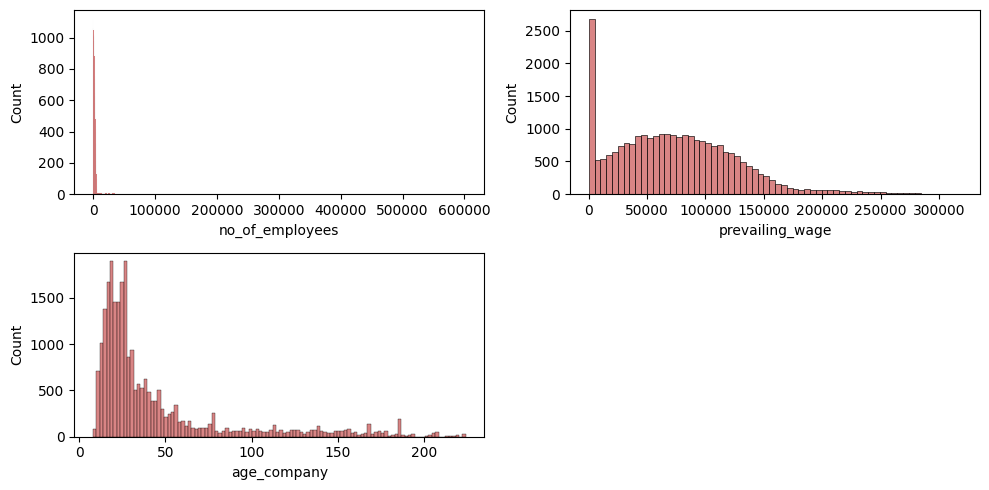

In [23]:
# Distribution of data before scaling
plt.figure(figsize=(10,5))
for i,col in enumerate(num_features.columns):
    plt.subplot(2,2,i+1)
    sns.histplot(x=X[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

* No of employees and Copmany age column is skewed
* Apply a power transform featurewise to make data more Gaussian-like.

Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.

Currently, PowerTransformer supports the Box-Cox transform and the Yeo-Johnson transform.

##### Checking Skewness

,no_of_employees,prevailing_wage,age_company
0,14513,592.2029,17
1,2412,83425.6500,22
2,44444,122996.8600,16
3,98,83434.0300,127
4,1082,149907.3900,19
...,...,...,...
25475,2601,77092.5700,16
25476,3274,279174.7900,18
25477,1121,146298.8500,114
25478,1918,86154.7700,137


In [27]:
X[num_features.columns].skew(axis=0)

no_of_employees    12.265260
prevailing_wage     0.755776
age_company         2.037301
dtype: float64

* age_company, no_of_employees are positively skewed
* Handle the outliers and check for skewness again

#### Apply Power Transformer to Check if it can reduces the outliers

In [30]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
transform_features = ['age_company', 'no_of_employees']
X_copy = pt.fit_transform(X[transform_features])

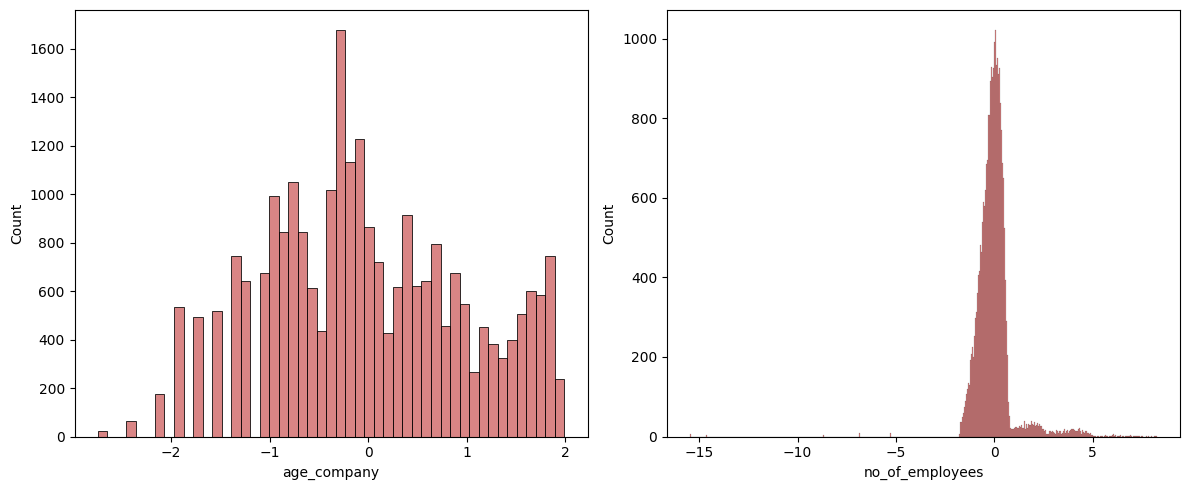

In [31]:
X_copy = pd.DataFrame(X_copy, columns= transform_features)
plt.figure(figsize=(12, 5))
for i, col in enumerate(transform_features):
    plt.subplot(1, 2, i+1)
    sns.histplot(x=X_copy[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

In [32]:
X_copy.skew(axis=0, skipna=True)

age_company        0.103264
no_of_employees    0.399339
dtype: float64

**Significant decrease in skewness**

### Feature Encoding and Scaling

**One Hot Encoding for Columns which had lesser unique values and not ordinal**

* One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

**Ordinal Encoding for Columns which has many unique categories**

* Ordinal encoding is used here as label encoder is supported for column transformer.
* Ordinal encoding is used for Ordinal Variable. Variable comprises a finite set of discrete values with a ranked ordering between values.

**Standard Scaler**

* Standardize features by removing the mean and scaling to unit variance.

**Power Transformer**

* Power transforms are a technique for transforming numerical input or output variables to have a Gaussian or more-Gaussian-like probability distribution.

In [33]:
for feature in cat_features:
    print(feature,':', df[feature].nunique())

continent : 6
education_of_employee : 4
has_job_experience : 2
region_of_employment : 5
unit_of_wage : 4
full_time_position : 2
case_status : 2


In [35]:
num_columns = list(num_features.columns)
num_columns

['no_of_employees', 'prevailing_wage', 'age_company']

#### Preprocessing using column transformer

In [36]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [39]:
or_columns = ['has_job_experience','full_time_position','education_of_employee']
oh_columns = ['continent','unit_of_wage','region_of_employment']
transform_columns= ['no_of_employees','age_company']

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()
ordinal_transformer = OrdinalEncoder()

transform_pipe = Pipeline(steps=[
    ('transformer',PowerTransformer(method='yeo-johnson'))
])

preprocessor = ColumnTransformer(
    [
        ('OneHotEncoder', oh_transformer, oh_columns),
        ('OrdinalEncoder', ordinal_transformer, or_columns),
        ('Transformer', transform_pipe, transform_columns),
        ('StandardScaler', numeric_transformer, num_columns)
    ]
)

In [40]:
X = preprocessor.fit_transform(X)
X

array([[ 0.        ,  1.        ,  0.        , ...,  0.38666657,
        -1.39853722, -0.65122993],
       [ 0.        ,  1.        ,  0.        , ..., -0.14228155,
         0.1698353 , -0.53321103],
       [ 0.        ,  1.        ,  0.        , ...,  1.69498375,
         0.91907852, -0.6748337 ],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.19871259,
         1.36027953,  1.63833662],
       [ 0.        ,  1.        ,  0.        , ..., -0.16387483,
         0.22150859,  2.18122353],
       [ 0.        ,  1.        ,  0.        , ..., -0.10805575,
        -0.06776315,  0.45814768]])

### Classification

In [41]:
# Resampling the minority class using SMOTE strategy

from imblearn.combine import SMOTEENN

smt = SMOTEENN(random_state=42, sampling_strategy='minority')

X_res, y_res = smt.fit_resample(X,y)

### Train test Split

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_res,y_res, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((13532, 23), (3383, 23))

## Model Training

In [44]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score,roc_curve 
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [45]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [46]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
     "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()
}

In [48]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    models_list = []
    accuracy_list = []
    auc= []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,model_train_recall,model_train_rocauc_score = evaluate_clf(y_train ,y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision, model_test_recall,model_test_rocauc_score = evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        auc.append(model_test_rocauc_score)
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['Model Name', 'Accuracy']).sort_values(by=['Accuracy'], ascending=False)
        
    return report

In [49]:
base_model_report =evaluate_models(X=X_res, y=y_res, models=models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9486
- F1 score: 0.9535
- Precision: 0.9479
- Recall: 0.9591
- Roc Auc Score: 0.9474


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9134
- F1 score: 0.9213
- Precision: 0.9200
- Recall: 0.9225
- Roc Auc Score: 0.9124


Gradient Boosting
Model performance for Training set
- Accuracy: 0.8840
- F1 score: 0.8919
- Precision: 0.8945
- Recall: 0.8894
- Roc Auc Score: 0.8835
----------------------------------
Model performance for Test set
- Accuracy: 0.8785
- F1 score: 0.8885
- Precision: 0.8960
- Recall: 0.8811
- Roc Auc Score: 0.8782


Logistic Regression
Model performance for Training 

c:\Users\nitin\anaconda3\envs\visa\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.9670
- F1 score: 0.9696
- Precision: 0.9604
- Recall: 0.9790
- Roc Auc Score: 0.9660
----------------------------------
Model performance for Test set
- Accuracy: 0.9362
- F1 score: 0.9427
- Precision: 0.9289
- Recall: 0.9569
- Roc Auc Score: 0.9339


XGBClassifier
Model performance for Training set
- Accuracy: 0.9786
- F1 score: 0.9802
- Precision: 0.9771
- Recall: 0.9834
- Roc Auc Score: 0.9782
----------------------------------
Model performance for Test set
- Accuracy: 0.9240
- F1 score: 0.9306
- Precision: 0.9334
- Recall: 0.9279
- Roc Auc Score: 0.9236


CatBoosting Classifier
Model performance for Training set
- Accuracy: 0.9539
- F1 score: 0.9570
- Precision: 0.9617
- Recall: 0.9522
- Roc Auc Score: 0.9540
----------------------------------
Model performance for Test set
- Accuracy: 0.9273
- F1 score: 0.9334
- Precision: 0.9390
- Recall: 0.9279
- Roc Auc Score: 0.9272


Support Vector Classifier
Model perfo

In [50]:
base_model_report

,Model Name,Accuracy
0,Random Forest,0.948566
4,K-Neighbors Classifier,0.936151
6,CatBoosting Classifier,0.927283
5,XGBClassifier,0.924032
1,Decision Tree,0.913390
2,Gradient Boosting,0.878510
7,Support Vector Classifier,0.863435
8,AdaBoost Classifier,0.849246
3,Logistic Regression,0.730417


**Here I can perform hyperparameter tuning for best performing models**

**I choose RandomForest, KNN, XGB for hyperparameter tuning**

In [53]:
import optuna

In [63]:
# Define an objective function to be minimized.
def objective(trial):

    # Invoke suggest methods of a Trial object to generate hyperparameters.
    model = trial.suggest_categorical('classifier', ['RandomForest','KNN','XGB'])
    if model == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 10, 20)
        max_depth = trial.suggest_int('max_depth',10,200)
        max_features = trial.suggest_categorical('max_features',['sqrt', 'log2', None])
        calssifier_obj = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,max_features=max_features)
    elif model == 'KNN':
        algorithm = trial.suggest_categorical('algorithm',['auto', 'ball_tree', 'kd_tree','brute'])
        n_neighbors = trial.suggest_int('n_neighbors', 3, 10)
        weights = trial.suggest_categorical('weights', ['uniform', 'distance'] )
        calssifier_obj = KNeighborsClassifier(algorithm=algorithm,n_neighbors=n_neighbors,weights=weights)
    else:
        max_depth = trial.suggest_int('max_depth', 3,10 )
        min_child_weight = trial.suggest_int('min_child_weight',1,6)
        calssifier_obj = XGBClassifier(max_depth=max_depth,min_child_weight=min_child_weight)

    calssifier_obj.fit(X_train, y_train)
    y_pred = calssifier_obj.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy  # An objective value linked with the Trial object.

study = optuna.create_study(direction='maximize', sampler= optuna.samplers.TPESampler())  # Create a new study.
study.optimize(objective, n_trials=50)  # Invoke optimization of the objective function.

[I 2024-10-15 12:16:57,585] A new study created in memory with name: no-name-98293125-89cb-469b-a626-d43ca44d1ece
[I 2024-10-15 12:16:57,736] Trial 0 finished with value: 0.9559562518474727 and parameters: {'classifier': 'KNN', 'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'}. Best is trial 0 with value: 0.9559562518474727.
[I 2024-10-15 12:16:58,503] Trial 1 finished with value: 0.948566361217854 and parameters: {'classifier': 'KNN', 'algorithm': 'ball_tree', 'n_neighbors': 8, 'weights': 'distance'}. Best is trial 0 with value: 0.9559562518474727.
[I 2024-10-15 12:16:58,587] Trial 2 finished with value: 0.967188885604493 and parameters: {'classifier': 'KNN', 'algorithm': 'brute', 'n_neighbors': 3, 'weights': 'distance'}. Best is trial 2 with value: 0.967188885604493.
[I 2024-10-15 12:16:59,120] Trial 3 finished with value: 0.9414720662134201 and parameters: {'classifier': 'RandomForest', 'n_estimators': 20, 'max_depth': 58, 'max_features': 'log2'}. Best is trial 2 with va

In [64]:
study.best_trial.value

0.967188885604493

In [65]:
study.best_trial.params

{'classifier': 'KNN',
 'algorithm': 'brute',
 'n_neighbors': 3,
 'weights': 'distance'}

The best model and params from optuna are 
{'classifier': 'KNN',
 'algorithm': 'brute',
 'n_neighbors': 3,
 'weights': 'distance'}
 with a accuracy score of 96.718

## Retraining with the best model and best parameters

In [67]:
best_model = KNeighborsClassifier(algorithm='brute', weights= 'distance', n_neighbors=3)

best_model.fit(X_train,y_train)

# Make predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Training set performance
model_train_accuracy, model_train_f1,model_train_precision,model_train_recall,model_train_rocauc_score = evaluate_clf(y_train ,y_train_pred)


# Test set performance
model_test_accuracy,model_test_f1,model_test_precision, model_test_recall,model_test_rocauc_score = evaluate_clf(y_test, y_test_pred)

print('Model performance for Training set')
print("- Accuracy: {:.4f}".format(model_train_accuracy))
print('- F1 score: {:.4f}'.format(model_train_f1)) 
print('- Precision: {:.4f}'.format(model_train_precision))
print('- Recall: {:.4f}'.format(model_train_recall))
print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

print('----------------------------------')

print('Model performance for Test set')
print('- Accuracy: {:.4f}'.format(model_test_accuracy))
print('- F1 score: {:.4f}'.format(model_test_f1))
print('- Precision: {:.4f}'.format(model_test_precision))
print('- Recall: {:.4f}'.format(model_test_recall))
print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))


Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9672
- F1 score: 0.9706
- Precision: 0.9561
- Recall: 0.9855
- Roc Auc Score: 0.9652


In [70]:
score = accuracy_score(y_test,y_test_pred)
cr = classification_report(y_test,y_test_pred)

print("FINAL MODEL 'KNN'")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

FINAL MODEL 'KNN'
Accuracy Score value: 0.9672
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1525
           1       0.96      0.99      0.97      1858

    accuracy                           0.97      3383
   macro avg       0.97      0.97      0.97      3383
weighted avg       0.97      0.97      0.97      3383



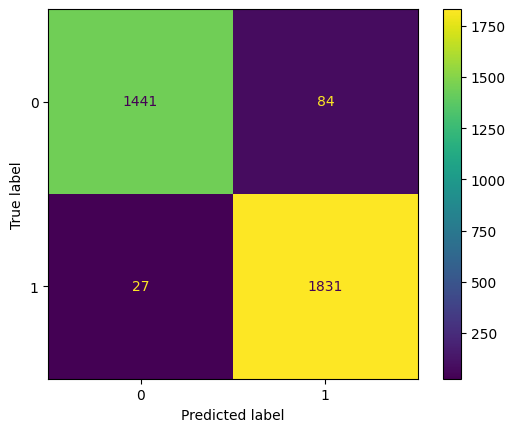

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)